In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import torch.nn as nn
import numpy as np

from models import PytorchModel
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from experiment import FeatureHandler, evaluate_model
import scipy.stats as stats
from evaluation import score_model, Score, Speaker

In [4]:
import matplotlib.pyplot as plt


In [5]:
class ColorSelector(nn.Module):
    def __init__(self, color_dim):
        super(ColorSelector, self).__init__()
        self.linear1 = nn.Linear(3*color_dim, color_dim)
        self.linear2 = nn.Linear(color_dim, 3)
        self.nll = nn.LogSoftmax(dim=2)
    
    def forward(self, colors):
        colors = colors.reshape(1, 1, -1)
        output = self.linear1(colors)
        output = nn.functional.relu(output)
        output = self.linear2(output)
        output = self.nll(output)
        return output

In [6]:
class ColorOnlyBaseline(PytorchModel):
    
    def train_iter(self, caption_tensor, color_tensor, target_tensor, criterion):
        model_output = self.model(color_tensor)
        loss = criterion(model_output.view(1, -1), target_tensor)
        return loss
        
    
    def predict(self, X):
        model_outputs = np.empty([len(X), 3])
        self.model.eval()
        with torch.no_grad():
            for i, feature in enumerate(X):
                caption, colors = feature
                color_tensor = torch.tensor([colors], dtype=torch.float)
                model_output = self.model(color_tensor)
                            
                model_output_np = model_output.view(-1).numpy()
                model_outputs[i] = model_output_np
        return model_outputs
                

In [7]:
baseline = ColorOnlyBaseline(ColorSelector)

In [10]:
# ok, let's train it
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth_10fold.csv", "../data/entries/dev_corpus_synth_10fold.pkl")
test_data_synth = MonroeData("../data/csv/test_corpus_synth_10fold.csv", "../data/entries/test_corpus_synth_10fold.pkl")

In [11]:
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"
color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)
feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)
feature_handler_test = FeatureHandler(train_data, test_data_synth, caption_phi, color_phi)
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()



In [9]:
train_targets[:10]

array([2, 2, 0, 1, 1, 2, 2, 1, 0, 1])

In [11]:
# model params
baseline_model = ColorOnlyBaseline(ColorSelector, optimizer=torch.optim.Adam, lr=0.001, num_epochs=5)
baseline_model.init_model(color_dim=54)

In [67]:
baseline_model.fit(train_features, train_targets)

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0010
0m 0s (0:1000 7.90%) 1.1131
0m 1s (0:2000 15.79%) 1.1006
0m 1s (0:3000 23.69%) 1.1002
0m 2s (0:4000 31.58%) 1.0988
0m 2s (0:5000 39.48%) 1.1051
0m 3s (0:6000 47.37%) 1.0953
0m 4s (0:7000 55.27%) 1.1004
0m 4s (0:8000 63.17%) 1.0900
0m 5s (0:9000 71.06%) 1.0962
0m 6s (0:10000 78.96%) 1.0962
0m 6s (0:11000 86.85%) 1.0990
0m 7s (0:12000 94.75%) 1.0970
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0915622524023056
---EPOCH 1---
0m 8s (1:0 0.00%) 0.0009
0m 8s (1:1000 7.90%) 1.0915
0m 9s (1:2000 15.79%) 1.0838
0m 10s (1:3000 23.69%) 1.0874
0m 10s (1:4000 31.58%) 1.0793
0m 11s (1:5000 39.48%) 1.0865
0m 12s (1:6000 47.37%) 1.0810
0m 12s (1:7000 55.27%) 1.0807
0m 13s (1:8000 63.17%) 1.0773
0m 14s (1:9000 71.06%) 1.0804
0m 15s (1:10000 78.96%) 1.0806
0m 15s (1:11000 86.85%) 1.0774
0m 16s (1:12000 94.75%) 1.0771
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0878375240663687
---EPOCH 2---
0m 17s (2:0 0.00%) 0.0006
0m 18s (2:1000 7.90%) 1.0811
0m 18s (2:2000 15

In [17]:
assess_features = feature_handler.test_features()
assess_targets = feature_handler.test_targets()

In [14]:
assess_features_test = feature_handler_test.test_features()
assess_targets_test = feature_handler_test.test_targets()

In [73]:
baseline_model.save_model("../model/baseline_model.params")

In [15]:
baseline_model.load_model("../model/baseline_model.params")

In [15]:
predictions = baseline_model.predict(assess_features)
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score
# evaluate_model(dev_data_synth, feature_handler, baseline_model, output_to_score, score_model)


Accuracy: 0.38058027079303675


(-0.01730340308843072, 0.6946773457416813)

In [16]:
predictions = baseline_model.predict(assess_features_test)
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score
evaluate_model(test_data_synth, feature_handler_test, baseline_model, output_to_score, score_model)

Accuracy: 0.37606060606060604


(0.04084638359524934, 0.34888975567659675)

It does bad. Yay. Accuracy just at random :) 

In [79]:
0.33 * 0.5 + 0.66 * 0.33

0.38280000000000003

In [23]:
from functools import partial

In [24]:
my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)

result = evaluate_model(dev_data_synth, feature_handler, baseline_model, output_to_score, my_score_model)

Got here to composite score
((-0.07429736658350086, 0.003088860918881754),           gameid  roundNum  numOutcome                            contents  \
0        synth-0         1           1                               green   
1        synth-0         2           1                                grey   
2        synth-0         3           1                         dark orange   
3        synth-0         4           1                              purple   
4        synth-0         5           1                              orange   
5        synth-0         6           1                           true grey   
6        synth-0         7           1                         dark purple   
7        synth-0         8           1                              purple   
8        synth-0         9           1                                blue   
9        synth-0        10           1                               brown   
10       synth-0        11           1                             

In [30]:
baseline_listener_eval_composite = result[1]
# first get just correlation between all model scores 
b_true_scores = baseline_listener_eval_composite.groupby('gameid').numOutcome.mean()
b_model_scores = baseline_listener_eval_composite.groupby('gameid').model_scores.mean()

In [31]:
# separate out conditions
baseline_listener_close = baseline_listener_eval_composite[baseline_listener_eval_composite.condition == "close"]
baseline_listener_split = baseline_listener_eval_composite[baseline_listener_eval_composite.condition == "split"]
baseline_listener_far =   baseline_listener_eval_composite[baseline_listener_eval_composite.condition == "far"]

baseline_listener_close_true_scores = baseline_listener_close.groupby('gameid').numOutcome.mean()
baseline_listener_close_model_scores = baseline_listener_close.groupby('gameid').model_scores.mean()

baseline_listener_split_true_scores =  baseline_listener_split.groupby('gameid').numOutcome.mean()
baseline_listener_split_model_scores = baseline_listener_split.groupby('gameid').model_scores.mean()

baseline_listener_far_true_scores =  baseline_listener_far.groupby('gameid').numOutcome.mean()
baseline_listener_far_model_scores = baseline_listener_far.groupby('gameid').model_scores.mean()

In [32]:
# now calculate the composite score from the eval_df we get back:
def composite_score(eval_df, speaker="gameid"):
    mean_scores = eval_df.groupby(speaker).numOutcome.mean()
    mean_numCleanWords = eval_df.groupby(speaker).numCleanWords.mean()
    mean_clkTime = eval_df.groupby(speaker).clkTime.mean()
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores
    return true_scores

baseline_listener_true_scores_composite = composite_score(baseline_listener_eval_composite)
baseline_listener_eval_composite.groupby('gameid').numOutcome.mean()
baseline_listener_model_scores_composite = baseline_listener_eval_composite.groupby('gameid').model_scores.mean()

In [33]:
baseline_listener_close_composite = composite_score(baseline_listener_close)
baseline_listener_split_composite = composite_score(baseline_listener_split)
baseline_listener_far_composite   = composite_score(baseline_listener_far)

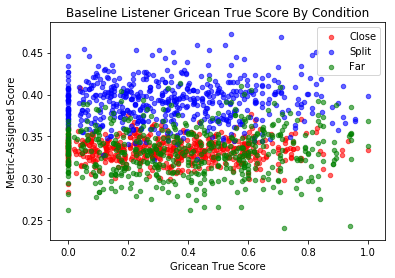

In [35]:
plt.scatter(baseline_listener_close_composite, baseline_listener_close_model_scores, color="red",   s=20, alpha=0.6, label="Close")
plt.scatter(baseline_listener_split_composite, baseline_listener_split_model_scores, color="blue",  s=20, alpha=0.6, label="Split")
plt.scatter(baseline_listener_far_composite,   baseline_listener_far_model_scores,   color="green", s=20, alpha=0.6, label="Far")
plt.legend()
plt.title("Baseline Listener Gricean True Score By Condition")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.savefig("../plots/Baseline_Gricean.png", dpi=300)
plt.show()

In [41]:
# Baseline Listener

caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn`
# caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with parameter files don't
color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)
feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi) # target function is initialized by default

for i in range(10):
    
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    model = ColorOnlyBaseline(ColorSelector, optimizer=torch.optim.Adam, lr=0.001, num_epochs=5)
    model.init_model(color_dim=54)

    model.fit(train_features, train_targets)
    
    model.save_model("../baseline_listener_samples/sample_" + str(i) + ".params")

---EPOCH 0---
0m 0s (0:0 0.00%) 0.0011
0m 1s (0:1000 7.90%) 1.1098
0m 2s (0:2000 15.79%) 1.1056
0m 4s (0:3000 23.69%) 1.1010
0m 5s (0:4000 31.58%) 1.0976
0m 7s (0:5000 39.48%) 1.0987
0m 10s (0:6000 47.37%) 1.0930
0m 12s (0:7000 55.27%) 1.0928
0m 14s (0:8000 63.17%) 1.0916
0m 16s (0:9000 71.06%) 1.0961
0m 18s (0:10000 78.96%) 1.0867
0m 20s (0:11000 86.85%) 1.0930
0m 23s (0:12000 94.75%) 1.0968
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.08969448625048
---EPOCH 1---
0m 25s (1:0 0.00%) 0.0010
0m 27s (1:1000 7.90%) 1.0909
0m 29s (1:2000 15.79%) 1.0923
0m 32s (1:3000 23.69%) 1.0928
0m 34s (1:4000 31.58%) 1.0803
0m 36s (1:5000 39.48%) 1.0829
0m 38s (1:6000 47.37%) 1.0797
0m 41s (1:7000 55.27%) 1.0737
0m 43s (1:8000 63.17%) 1.0753
0m 45s (1:9000 71.06%) 1.0753
0m 48s (1:10000 78.96%) 1.0643
0m 51s (1:11000 86.85%) 1.0758
0m 53s (1:12000 94.75%) 1.0763
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.0869658613403639
---EPOCH 2---
0m 55s (2:0 0.00%) 0.0011
0m 58s (2:1000 7.90%) 1.0831
1m 1s (2:

0m 12s (1:1000 7.90%) 1.1007
0m 13s (1:2000 15.79%) 1.1025
0m 14s (1:3000 23.69%) 1.1026
0m 15s (1:4000 31.58%) 1.0963
0m 16s (1:5000 39.48%) 1.0983
0m 16s (1:6000 47.37%) 1.1032
0m 17s (1:7000 55.27%) 1.1015
0m 18s (1:8000 63.17%) 1.0996
0m 19s (1:9000 71.06%) 1.1017
0m 20s (1:10000 78.96%) 1.0979
0m 22s (1:11000 86.85%) 1.1007
0m 23s (1:12000 94.75%) 1.1016
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.1014436001578967
---EPOCH 2---
0m 24s (2:0 0.00%) 0.0010
0m 25s (2:1000 7.90%) 1.0962
0m 26s (2:2000 15.79%) 1.0976
0m 27s (2:3000 23.69%) 1.1025
0m 29s (2:4000 31.58%) 1.0999
0m 32s (2:5000 39.48%) 1.1010
0m 36s (2:6000 47.37%) 1.1017
0m 42s (2:7000 55.27%) 1.0983
0m 47s (2:8000 63.17%) 1.0961
0m 53s (2:9000 71.06%) 1.1014
0m 59s (2:10000 78.96%) 1.0936
1m 5s (2:11000 86.85%) 1.0984
1m 11s (2:12000 94.75%) 1.0957
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.104195787191391
---EPOCH 3---
1m 16s (3:0 0.00%) 0.0008
1m 22s (3:1000 7.90%) 1.0907
1m 28s (3:2000 15.79%) 1.1001
1m 33s (3:300

0m 24s (2:1000 7.90%) 1.1034
0m 26s (2:2000 15.79%) 1.1027
0m 27s (2:3000 23.69%) 1.0978
0m 29s (2:4000 31.58%) 1.0988
0m 30s (2:5000 39.48%) 1.0997
0m 31s (2:6000 47.37%) 1.0981
0m 32s (2:7000 55.27%) 1.1016
0m 33s (2:8000 63.17%) 1.1014
0m 34s (2:9000 71.06%) 1.0985
0m 35s (2:10000 78.96%) 1.0999
0m 36s (2:11000 86.85%) 1.0985
0m 37s (2:12000 94.75%) 1.1001
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.1033852373361588
---EPOCH 3---
0m 38s (3:0 0.00%) 0.0011
0m 39s (3:1000 7.90%) 1.1005
0m 40s (3:2000 15.79%) 1.1024
0m 42s (3:3000 23.69%) 1.0950
0m 44s (3:4000 31.58%) 1.0945
0m 46s (3:5000 39.48%) 1.0988
0m 48s (3:6000 47.37%) 1.0976
0m 50s (3:7000 55.27%) 1.1019
0m 52s (3:8000 63.17%) 1.0990
0m 54s (3:9000 71.06%) 1.0956
0m 55s (3:10000 78.96%) 1.0993
0m 57s (3:11000 86.85%) 1.1005
0m 59s (3:12000 94.75%) 1.0976
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.1060820327599843
---EPOCH 4---
1m 1s (4:0 0.00%) 0.0010
1m 3s (4:1000 7.90%) 1.0987
1m 4s (4:2000 15.79%) 1.1017
1m 6s (4:3000 

0m 49s (3:1000 7.90%) 1.0966
0m 50s (3:2000 15.79%) 1.1011
0m 52s (3:3000 23.69%) 1.0920
0m 53s (3:4000 31.58%) 1.0954
0m 55s (3:5000 39.48%) 1.0972
0m 56s (3:6000 47.37%) 1.0943
0m 58s (3:7000 55.27%) 1.0928
1m 0s (3:8000 63.17%) 1.1039
1m 1s (3:9000 71.06%) 1.0942
1m 3s (3:10000 78.96%) 1.0877
1m 4s (3:11000 86.85%) 1.1027
1m 5s (3:12000 94.75%) 1.1000
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.107728648940722
---EPOCH 4---
1m 7s (4:0 0.00%) 0.0010
1m 8s (4:1000 7.90%) 1.0985
1m 10s (4:2000 15.79%) 1.1000
1m 11s (4:3000 23.69%) 1.0888
1m 13s (4:4000 31.58%) 1.0931
1m 14s (4:5000 39.48%) 1.0961
1m 16s (4:6000 47.37%) 1.0928
1m 17s (4:7000 55.27%) 1.0907
1m 19s (4:8000 63.17%) 1.1007
1m 20s (4:9000 71.06%) 1.0855
1m 21s (4:10000 78.96%) 1.0859
1m 23s (4:11000 86.85%) 1.0947
1m 24s (4:12000 94.75%) 1.0990
AFTER EPOCH 2999 - AVERAGE VALIDATION LOSS: 1.109630350112915


In [ ]:
with open('../results/baseline_listener_assessment.pkl', 'rb') as file:
    pickle.dump(result, file)